<a href="https://colab.research.google.com/github/TrzeciakPiotr2300/Uczenie_Maszynowe_2025/blob/main/HW09_multi-layer-perceptron-MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Multi Layer Perceptron Notation
---------------------------------

In this workshop we will be classifying 28 by 28 images into 10 classes. Thus, a four layer perceptron (our classificator) we will work further with can be defined as
$\hat f:\mathbb{R}^{28\cdot 28} \rightarrow \mathbb{R}^{10}$ defined as

$$\hat f \left(x; W_1, W_2, W_3, W_4, b_1, b_2, b_3, b_4 \right) =  W_4 \left[ W_3 \left[ W_2 \left[ W_1 x  + b_1 \right]_+  + b_2 \right]_+  + b_3 \right]_+ + b_4,$$

where matrices $W_1, \ldots, W_4$ are tensors of order two (matrices) with matching dimensions and bias terms $b_1, \ldots, b_4$ are tensors of order one (vectors) of matching dimensions, and we are using ReLU activation.

Note, that there is no nonlinear activation after the last layer in our neural network. **There is an implicit softmax applied while cross entropy loss is calculated by `torch.nn.functional`.**


# Reading MNIST Dataset to Play with It
--------------------

In [1]:
import torch
import torchvision
from matplotlib import pyplot

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=None)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.99MB/s]


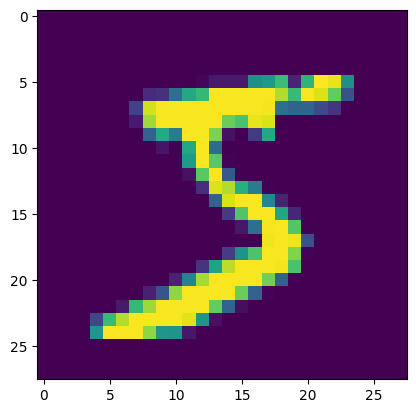

In [2]:
train_image, train_target = trainset[0]    #let us examine the 0-th sample
pyplot.imshow(train_image)
pyplot.show()

In [3]:
(trainset.data.numpy().mean()/255.0, trainset.data.numpy().std()/255.0)   #MNIST datapoints are RGB integers 0-255

(np.float64(0.1306604762738429), np.float64(0.30810780385646264))

# Task
---------------

Why do we need to normalize the data, and not feed the NN with the 0-255 integers?

In [4]:
transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
      torchvision.transforms.Normalize((0.1307), (0.3081))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)   #we do shuffle it to give more randomizations to training epochs

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)

# MLP Definition
-----------------

Your job now is to take the (fully functional) definition of the MLP structure and get rid off the Sequential layer.


In [5]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1 * 28 * 28, 1024)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 2048)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(2048, 256)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.05)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.dropout(x)
        return x



# Training Loop
----------------------

In [6]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net = MLP().to(device)
optimizer = torch.optim.Adam(net.parameters(), 0.001)   #initial and fixed learning rate of 0.001.

net.train()    #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing traning
for epoch in range(8):  #  an epoch is a training run through the whole data set

    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        batch_inputs = batch_inputs.to(device)  #explicitly moving the data to the target device
        batch_labels = batch_labels.to(device)

        #batch_inputs.squeeze(1)     #alternatively if not for a Flatten layer, squeeze() could be used to remove the second order of the tensor, the Channel, which is one-dimensional (this index can be equal to 0 only)

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)   #this line calls the forward(self, x) method of the MLP object. Please note, that the last layer of the MLP is linear
                                            #and MLP doesn't apply
                                            #the nonlinear activation after the last layer
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function
        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()       #this computes gradients as we have seen in previous workshops
        optimizer.step()     #but this line in fact updates our neural network.
                                ####You can experiment - comment this line and check, that the loss DOE


Working on cuda
epoch: 0 batch: 0 current batch loss: 2.3053691387176514
epoch: 0 batch: 1 current batch loss: 2.072006940841675
epoch: 0 batch: 2 current batch loss: 1.6182340383529663
epoch: 0 batch: 3 current batch loss: 1.1015889644622803
epoch: 0 batch: 4 current batch loss: 0.8838932514190674
epoch: 0 batch: 5 current batch loss: 1.7483510971069336
epoch: 0 batch: 6 current batch loss: 1.4360312223434448
epoch: 0 batch: 7 current batch loss: 1.2736397981643677
epoch: 0 batch: 8 current batch loss: 1.2546073198318481
epoch: 0 batch: 9 current batch loss: 1.0920928716659546
epoch: 0 batch: 10 current batch loss: 0.8251413702964783
epoch: 0 batch: 11 current batch loss: 0.6862395405769348
epoch: 0 batch: 12 current batch loss: 0.6951696872711182
epoch: 0 batch: 13 current batch loss: 0.7298570871353149
epoch: 0 batch: 14 current batch loss: 0.7445732951164246
epoch: 0 batch: 15 current batch loss: 0.7173103094100952
epoch: 0 batch: 16 current batch loss: 0.6331873536109924
epoch: 0 

In [7]:
torch.save(net.state_dict(), "mlp_model.pth")


# Testing
----------------------

Correct the code below so it works.

In [8]:
good = 0
wrong = 0

net.eval()              #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing evaluation
with torch.no_grad():   #it prevents that the net learns during evalution. The gradients are not computed, so this makes it faster, too
    for batch, data in enumerate(testloader): #batches in test are of size 1
        datapoint, label = data

        prediction = net(datapoint.to(device))                  #prediction has values representing the "prevalence" of the corresponding class
        classification = torch.argmax(prediction)    #the class is the index of maximal "prevalence"

        if classification.item() == label.item():
            good += 1
        else:
            wrong += 1

print("accuracy = ", good/(good+wrong))

accuracy =  0.9812


# **Homework Assignment - *Do Androids Dream of Electric Sheep?***

-------------------------------------  

"Do Androids Dream of Electric Sheep?" – the famous title of Philip K. Dick’s novel – raises a fascinating question: if artificial intelligence could dream, what would it see?  

In this assignment, we explore a phenomenon known as **neural network dreams**, where instead of optimizing a neural network's weights, we **optimize the input itself** to achieve a desired classification outcome. Given a fully trained MNIST classification network, your goal is to manipulate its inputs so that it confidently predicts each digit from 0 to 9, starting from pure noise.  

## **Tasks Description**  

During this class we designed and trained a **MNIST classification neural network**, which takes a **batch of grayscale images** of size **$28 \times 28$** as input and outputs a probability distribution over the 10 digit classes (0–9). However, instead of using real MNIST images, you will **treat the input batch itself as a set of trainable parameters** and optimize it so that the network classifies each image as a specific digit.  



----------------------------------
**1**. Your first task is to generate **a batch of 10 images**, where each image is
   classified as one of the digits **0, 1, 2, ..., 9**, starting from an initial batch of ten random Gaussian noise images.  

   Discuss the following question: do the generated images resemble real MNIST digits? Why or why not?

### **Optimization Process for Task 1**  

1. Start with a **batch of 10 random Gaussian noise images** as the initial input and $(0, 1, 2, \ldots, 9)$ as the expected output batch of target digits.  
2. Define the objective: maximize the neural network's confidence for the corresponding target digit for each image in the batch.  
3. Use **gradient descent** to modify the pixels in each image, making the network classify each one as the assigned digit.  
4. Repeat until the network assigns suffieciently high confidence to each image’s target class.

In [9]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Generating images on {device}")

# Target labels: 0-9
targets = torch.arange(10, device=device)

# Start with random noise
images = torch.randn((10, 1, 28, 28), device=device, requires_grad=True)

# Optimizer
optimizer = torch.optim.Adam([images], lr=0.1)

net.eval()

# Optimize input to be classified as each digit
for step in range(14000):
    optimizer.zero_grad()
    outputs = net(images)
    loss = F.cross_entropy(outputs, targets)
    loss.backward()
    optimizer.step()

# Get final predictions and probabilities
with torch.no_grad():
    outputs = net(images)
    probs = F.softmax(outputs, dim=1).cpu()  # shape (10, 10)
    preds = outputs.argmax(dim=1)

final_images = images.detach().clamp(0, 1).cpu()


Generating images on cuda


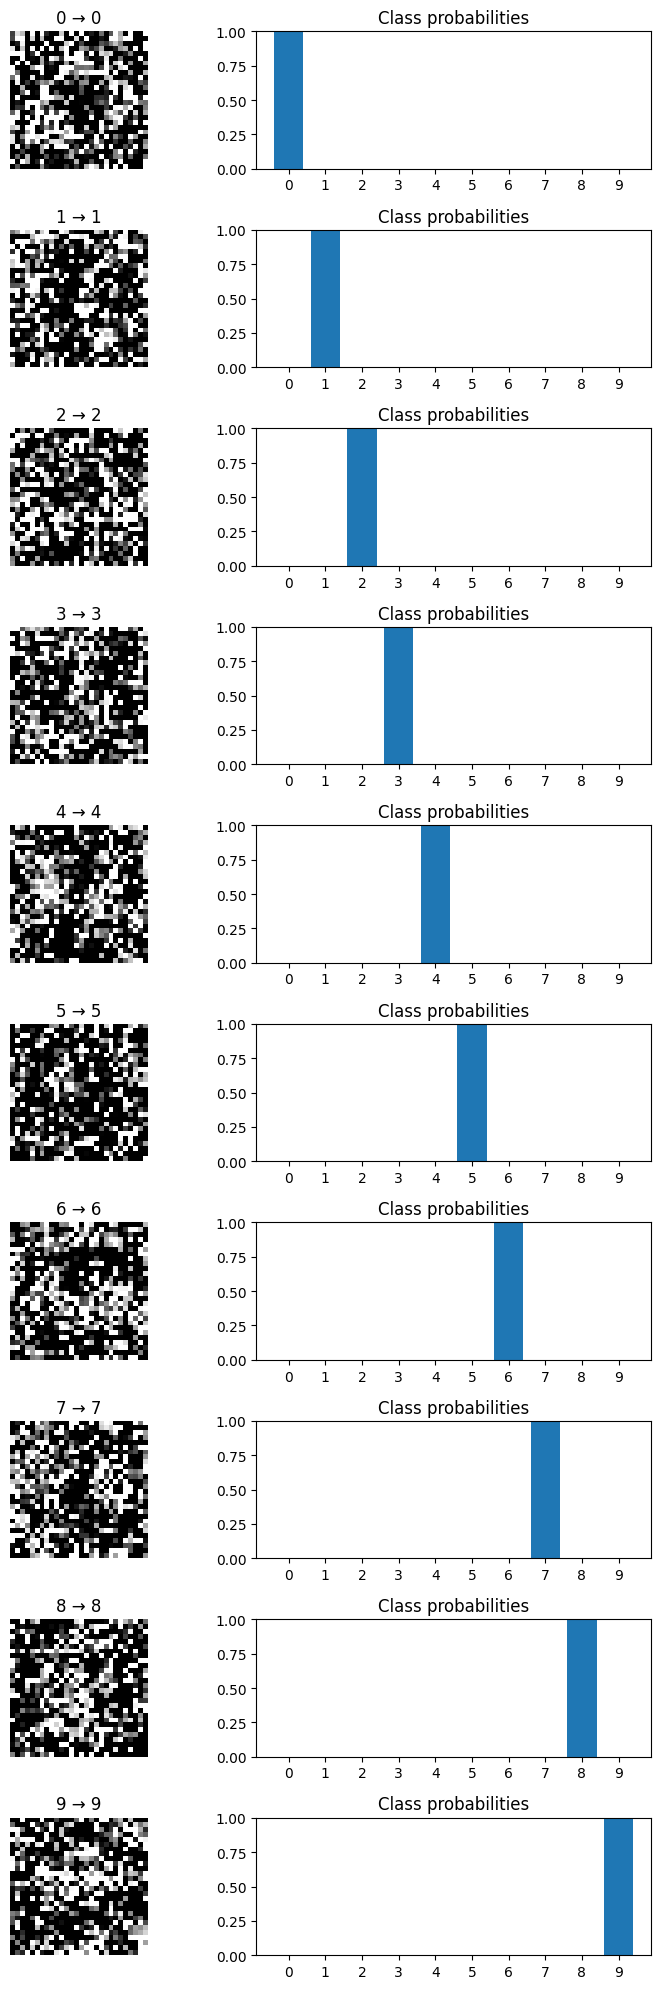

In [10]:
# Plotting
fig, axes = plt.subplots(10, 2, figsize=(8, 20))

for i in range(10):
    # Show image
    axes[i, 0].imshow(final_images[i][0], cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f"{i} → {preds[i].item()}")

    # Show probability bar plot
    axes[i, 1].bar(range(10), probs[i])
    axes[i, 1].set_ylim(0, 1)
    axes[i, 1].set_xticks(range(10))
    axes[i, 1].set_title("Class probabilities")

plt.tight_layout()
plt.show()


---------------------------------------
2. Discuss, how you would approach a second task of
   generating an image that   
   bares similarity to two or more digits simultaneously. **Implement your idea to see the results.**

We could set the target probabilities of two numbers as $\frac{1}{2}$ and zero the rest. Then perform the optimization process as before but with a difference, that the loss will bo wrt. image probability. We then have to use different loss - not cross entrophy since we're not tagreting input and labels but probability. Natural choise is then Kullback-Laiber divergence from **torch.nn.functional.kl_div**.




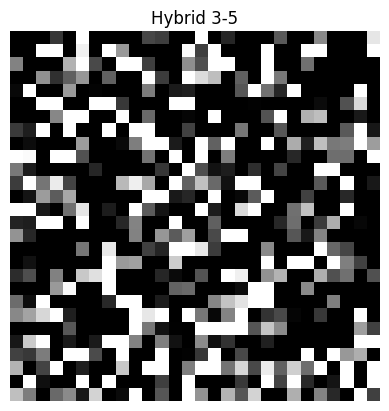

Class probabilities: [0.  0.  0.  0.5 0.  0.5 0.  0.  0.  0. ]
Target probabilities: [0.  0.  0.  0.5 0.  0.5 0.  0.  0.  0. ]
Loss: 0.0001747608184814453
Max probability: 0.49991270899772644
Max target probability: 0.5
Max difference: 8.729100227355957e-05
Difference between max probabilities: 8.729100227355957e-05


In [11]:
# Task 2: Generate a hybrid digit (e.g., 3 and 5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.eval()

# Initialize image with noise
image = torch.randn((1, 1, 28, 28), device=device, requires_grad=True)

# Target distribution (equal probability for classes 3 and 5)
target_probs = torch.zeros(10, device=device)
target_probs[[3, 5]] = 0.5
target_probs = target_probs.unsqueeze(0)  # Add batch dimension

optimizer = torch.optim.Adam([image], lr=0.01)

for step in range(1000):
    optimizer.zero_grad()
    outputs = net(image)
    log_probs = F.log_softmax(outputs, dim=1)
    loss = F.kl_div(log_probs, target_probs, reduction='batchmean')
    loss.backward()
    optimizer.step()

# Visualize and check probabilities
final_image = image.detach().clamp(0, 1).cpu()
plt.imshow(final_image[0][0], cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.title("Hybrid 3-5")
plt.show()

with torch.no_grad():
    outputs = net(image)
    probs = F.softmax(outputs, dim=1)
    print("Class probabilities:", probs[0].cpu().numpy().round(3))
    print("Target probabilities:", target_probs[0].cpu().numpy().round(3))
    print("Loss:", loss.item())
    print("Max probability:", probs[0].max().item())
    print("Max target probability:", target_probs[0].max().item())
    print("Max difference:", (probs[0] - target_probs[0]).abs().max().item())
    print("Difference between max probabilities:", (probs[0].max() - target_probs[0].max()).abs().item())


------------------------------------------
3. Third task: repeat the previous tasks with an additional L2 penalty on noise within the images. Experiment with adding `lambda_l2 * dreamed_input_batch.pow(2).mean()` loss term, with `lambda_l2` being the penalty cooefficient within an exponential progression, say from 0.001 to 10.0. Are the new digits recognized correctly? How does the penalty impact the digit quality? Explain.

In [88]:
# Task 3: L2 Regularization Experiment
lambdas = [0.001, 0.01, 0.1, 1.0, 10.0]
results = {}

for lambda_l2 in lambdas:
    print(f"\nExperimenting with λ = {lambda_l2}")
    images = torch.randn((10, 1, 28, 28), device=device, requires_grad=True)
    targets = torch.arange(10, device=device)

    optimizer = torch.optim.Adam([images], lr=0.01)

    for step in range(14000):
        optimizer.zero_grad()
        outputs = net(images)
        ce_loss = F.cross_entropy(outputs, targets)
        l2_loss = lambda_l2 * images.pow(2).mean()
        total_loss = ce_loss + l2_loss
        total_loss.backward()
        optimizer.step()

    # Store results
    final_images = images.detach().clamp(0, 1).cpu().clone()
    with torch.no_grad():
        probs = F.softmax(net(images), dim=1)
        confidence = probs[torch.arange(10), targets].mean().item()

    results[lambda_l2] = {
        'images': final_images,
        'confidence': confidence
    }



Experimenting with λ = 0.001

Experimenting with λ = 0.01

Experimenting with λ = 0.1

Experimenting with λ = 1.0

Experimenting with λ = 10.0


In [89]:
my_dict = results.copy()

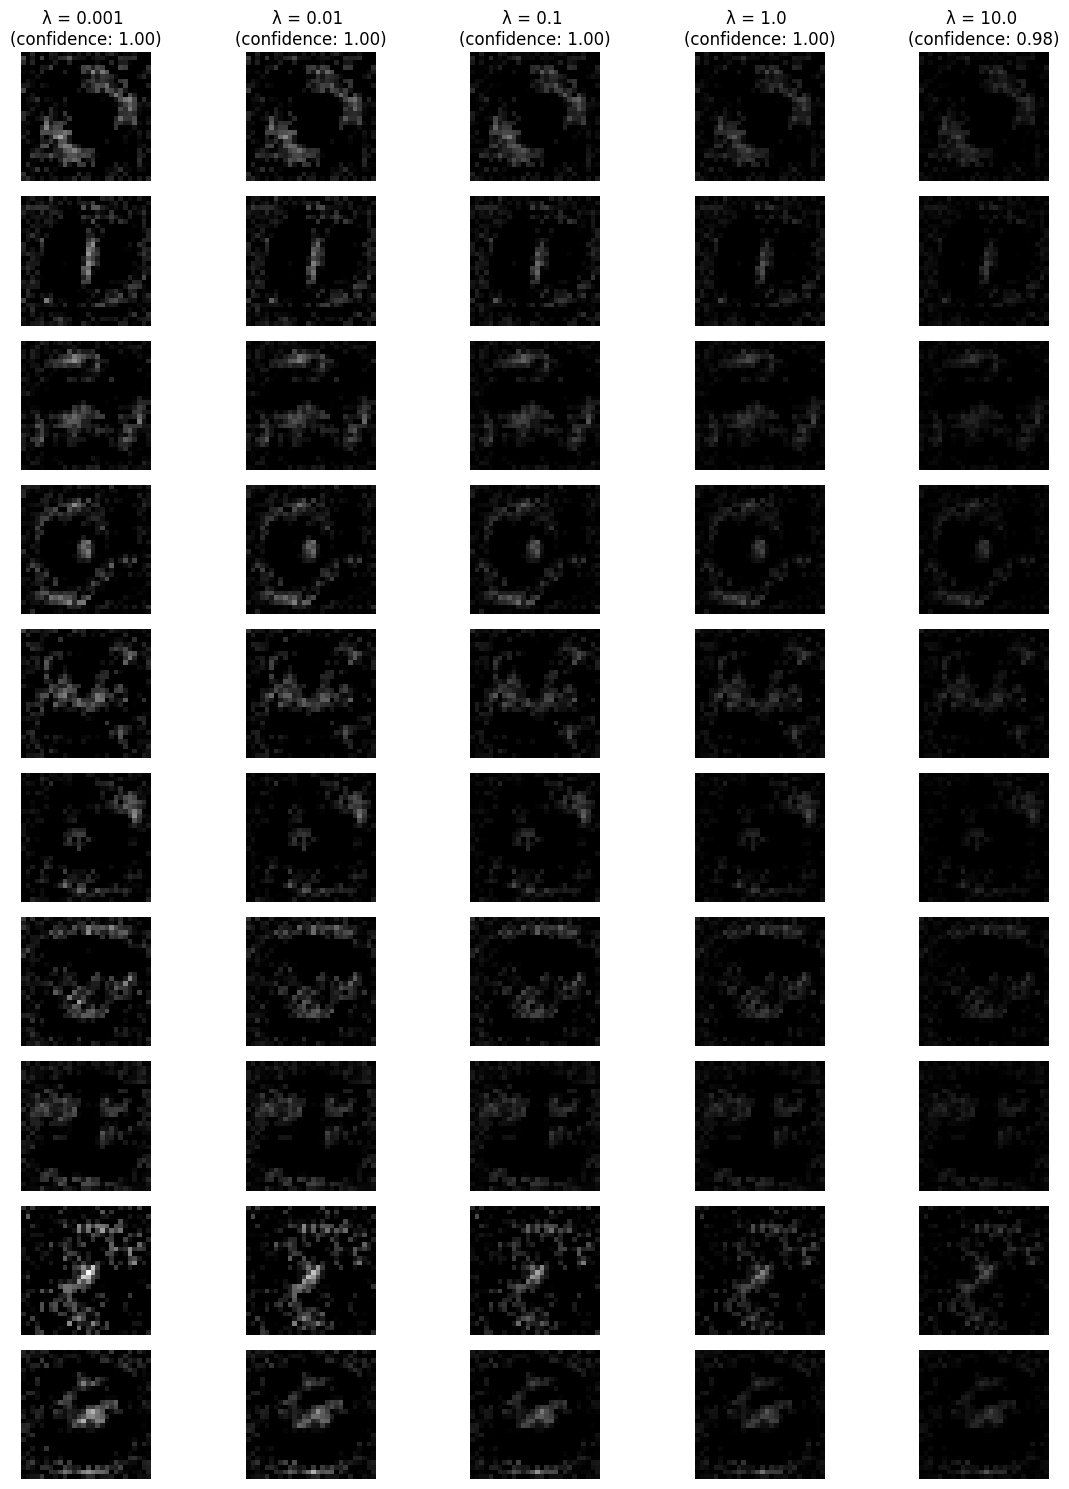

In [109]:
fig, axs = plt.subplots(nrows=10, ncols=5, figsize=(12, 15))

# Use a consistent intensity scale across all images
vmin, vmax = 0, 1

for col, lambda_l2 in enumerate(lambdas):
    final_images = results[lambda_l2]['images']
    for row in range(10):
        axs[row, col].imshow(final_images[row][0], cmap='gray', vmin=vmin, vmax=vmax)
        axs[row, col].axis('off')
    axs[0, col].set_title(f"λ = {lambda_l2} \n(confidence: {results[lambda_l2]['confidence']:.2f})")

plt.tight_layout()
plt.show()


Fortunatelly, the images are begining to be more clear to read and to interpret. The best $\lambda$ seem to be somwere in the middle - {0.01 and 0.1}, where there is reduced noise while maintaining digit structure and the digits here are simmilar to those we trained our MLP.net() on in part 1.

For better image reconstructing, check my next solution using CNN (convolutional NN) as a next homework.